In [1]:
import sys
sys.path.insert(0, '..')

%load_ext tools.prov_magics
import tools.view.provn

3


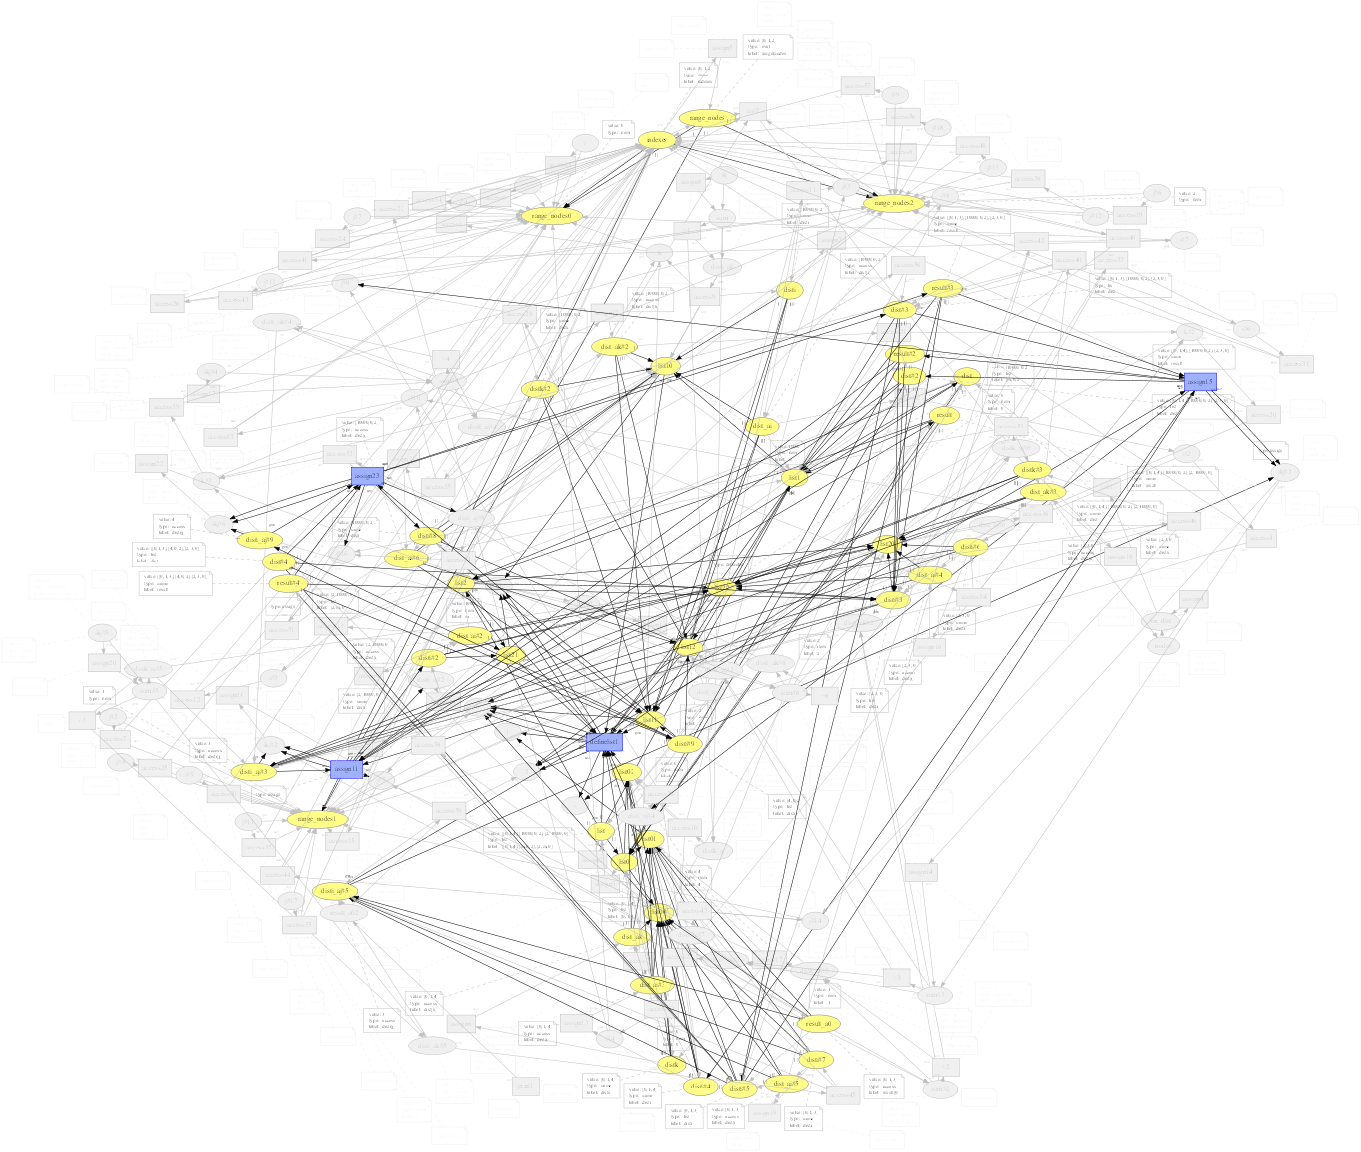

{1: [('entity', 2),
     ('activity', 1),
     ('used', 1),
     ('wasDerivedFrom', 1),
     ('wasGeneratedBy', 1)],
 2: [('entity', 19),
     ('hadMember', 18),
     ('wasGeneratedBy', 15),
     ('used', 11),
     ('wasDerivedFrom', 11),
     ('activity', 3)],
 7: [('entity', 2),
     ('activity', 2),
     ('used', 2),
     ('wasGeneratedBy', 2),
     ('wasDerivedFrom', 1)],
 8: [('hadMember', 6),
     ('entity', 5),
     ('wasGeneratedBy', 5),
     ('activity', 2),
     ('used', 2),
     ('wasDerivedFrom', 1)],
 9: [('used', 6),
     ('entity', 3),
     ('activity', 3),
     ('wasDerivedFrom', 3),
     ('wasGeneratedBy', 3)],
 10: [('hadMember', 18),
      ('used', 12),
      ('entity', 6),
      ('activity', 6),
      ('wasDerivedFrom', 6),
      ('wasGeneratedBy', 6)],
 11: [('used', 18),
      ('entity', 9),
      ('activity', 9),
      ('wasDerivedFrom', 9),
      ('wasGeneratedBy', 9)],
 13: [('hadMember', 36),
      ('used', 24),
      ('entity', 12),
      ('activity', 12),
  

In [2]:
from pprint import pprint

import importlib
import tools.annotations as prov
importlib.reload(prov)
prov.reset_prov("../images/plain_prov/temp/")

HIDE = prov.HIDE

def cond(ents):
    return ents


# Line 1
m = 10000 # max value

with prov.desc("L1 - assign", line=1):
    e_n10000 = prov.entity("10000", "10000", "literal", None, attrs=HIDE)

    e_m = prov.entity("m", "10000", "name", "m", attrs=HIDE)
    prov.activity("assign", [(e_m, e_n10000)], attrs=HIDE)


# Line 2
result = dist = [
    [0, 1, 4],
    [m, 0, 2],
    [2, m, 0],
]

with prov.desc("L2 - list definition / assign", line=2):
    
    with prov.desc("L2 - list definition"):
        e_n0 = prov.entity("0", "0", "literal", None, attrs=HIDE)
        e_n1 = prov.entity("1", "1", "literal", None, attrs=HIDE)
        e_n2 = prov.entity("2", "2", "literal", None, attrs=HIDE)
        e_n4 = prov.entity("4", "4", "literal", None, attrs=HIDE)

        prov_dist = [
            [e_n0, e_n1, e_n4],
            [e_m, e_n0, e_n2],
            [e_n2, e_m, e_n0],
        ]
        prov_label = [
            ["0", "1", "4"],
            ["m", "0", "2"],
            ["2", "m", "0"]
        ]
            
        e_list, rows = prov.define_array("list", dist, prov_label, "list", prov.hadMember)

        derived = []
        generated = [e_list]
        for i, row in enumerate(rows):
            generated.append(row[0])
            for j, ent in enumerate(row[1]):
                derived.append((ent, prov_dist[i][j]))
        row_ents = [row[0] for row in rows]
            
        prov.activity("definelist", derived, generated=generated)
        
    with prov.desc("L2 - assign"):
        e_dist = prov.entity("dist", repr(dist), "name", "dist")
        prov.had_members(e_dist, row_ents)
        prov.activity("assign", [(e_dist, e_list)], attrs=HIDE)

        e_result = prov.entity("result", repr(result), "name", "result")
        prov.had_members(e_result, row_ents)
        prov.activity("assign", [(e_result, e_list)], attrs=HIDE)
        

# Line 7
nodes = len(dist)

with prov.desc("L7 - func call / assign", line=7):
    e_ret = prov.entity("len_dist", repr(nodes), "eval", "len(dist)", attrs=HIDE)
    prov.activity("call", [], [e_dist], [e_ret], label="len", attrs=HIDE)
    
    e_nodes = prov.entity("nodes", repr(nodes), "name", "nodes", attrs=HIDE)
    prov.activity("assign", [(e_nodes, e_ret)], attrs=HIDE)

# Line 8
indexes = range(nodes)

with prov.desc("L8 - func call / list assign", line=8):
    e_ret = prov.entity("range_nodes", repr(list(indexes)), "eval", "range(nodes)")
    e_items = []
    for i in indexes:
        e_item = prov.entity("range_nodes{}".format(i), str(i), "item", None)
        prov.hadMember(e_ret, e_item, str(i))
        e_items.append(e_item)
    prov.activity("call", [], [e_nodes], [e_ret] + e_items, label="range", attrs=HIDE)
    
    e_indexes = prov.entity("indexes", repr(list(indexes)), "name", "indexes")
    prov.had_members(e_indexes, e_items)
    prov.activity("assign", [(e_indexes, e_ret)], attrs=HIDE)

    
# Line 9
for k in indexes:
    with prov.desc("L9 - loop access", line=9):
        e_k = prov.entity("k", k, "name", "k", attrs=HIDE)
        prov.activity("access", [(e_k, prov.DICTS[e_indexes][repr(k)])], used=[e_indexes], attrs=HIDE)
    
    # Line 10
    distk = dist[k]
    
    with prov.desc("L10 - access / assign", line=10):
        e_dist_ak = prov.entity("dist_ak", repr(distk), "access", "dist[k]")
        item = prov.DICTS[e_dist][str(k)]
        prov.had_members(e_dist_ak, prov.DICTS[item])
        prov.activity("access", [(e_dist_ak, item)], used=[e_dist, e_k], attrs=HIDE)

        e_distk = prov.entity("distk", repr(distk), "name", "distk")
        prov.had_members(e_distk, prov.DICTS[item])
        prov.activity("assign", [(e_distk, e_dist_ak)], attrs=HIDE)
        
    # Line 11
    for i in indexes:
        with prov.desc("L11 - loop access", line=11):
            e_i = prov.entity("i", i, "name", "i", attrs=HIDE)
            prov.activity("access", [(e_i, prov.DICTS[e_indexes][repr(i)])], used=[e_indexes], attrs=HIDE)
        
        # Line 12
        with prov.desc("L12 - condition", line=12):
            cond([e_i, e_k])
        if i == k: continue
        
        
        # Line 13
        disti = dist[i]
        
        with prov.desc("L13 - access / assign", line=13):
            e_dist_ai = prov.entity("dist_ai", repr(disti), "access", "dist[i]")
            item = prov.DICTS[e_dist][str(i)]
            prov.had_members(e_dist_ai, prov.DICTS[item])
            prov.activity("access", [(e_dist_ai, item)], used=[e_dist, e_i], attrs=HIDE)

            e_disti = prov.entity("disti", repr(disti), "name", "disti")
            prov.had_members(e_disti, prov.DICTS[item])
            prov.activity("assign", [(e_disti, e_dist_ai)], attrs=HIDE)
        
        # Line 14
        for j in indexes:
            
            with prov.desc("L14 - loop access", line=14):
                e_j = prov.entity("j", j, "name", "j", attrs=HIDE)
                prov.activity("access", [(e_j, prov.DICTS[e_indexes][repr(j)])], used=[e_indexes], attrs=HIDE)
            
            # Line 15
            with prov.desc("L15 - condition", line=15):
                cond([e_j, e_k, e_i])
            if j == k or j == i: continue
            
            # Line 16
            ikj = disti[k] + distk[j]
            
            with prov.desc("L16 - access / access / operation / assign", line=16):
                e_disti_ak = prov.entity("disti_ak", repr(disti[k]), "access", "disti[k]", attrs=HIDE)
                item = prov.DICTS[e_disti][str(k)]
                prov.activity("access", [(e_disti_ak, item)], used=[e_disti, e_k], attrs=HIDE)
                
                e_distk_aj = prov.entity("distk_aj", repr(distk[j]), "access", "distk[j]", attrs=HIDE)
                item = prov.DICTS[e_distk][str(j)]
                prov.activity("access", [(e_distk_aj, item)], used=[e_distk, e_j], attrs=HIDE)
                
                e_sum = prov.entity("sum", repr(ikj), "operation", "disti[k] + distk[j]", attrs=HIDE)
                prov.activity("+", [(e_sum, e_disti_ak, e_distk_aj)], attrs=HIDE)
                
                e_ikj = prov.entity("ikj", repr(ikj), "name", "ikj", attrs=HIDE)
                prov.activity("assign", [(e_ikj, e_sum)], attrs=HIDE)
            
            
            # Line 17
            with prov.desc("L17 - access", line=17):
                e_disti_aj = prov.entity("disti_aj", repr(disti[j]), "access", "disti[j]", attrs=HIDE)
                item = prov.DICTS[e_disti][str(j)]
                prov.activity("access", [(e_disti_aj, item)], used=[e_disti, e_j], attrs=HIDE)
                ucond = cond([e_disti_aj, e_ikj])
            
            if disti[j] > ikj:
                
                # Line 18
                disti[j] = ikj
                
                with prov.desc("L18 - part assign with propagation", line=18):
                    derived = []
                    used = [e_disti, e_j] 
                    used += ucond # from if
                    generated = []
                    
                    
                    e_disti_aj = prov.entity("disti_aj", repr(ikj), "access", "disti[j]")
                    new_e_disti = prov.update("disti", e_disti, j, e_disti_aj, disti, "disti")
                    derived.append((e_disti_aj, e_ikj))
                    generated.append(new_e_disti)
                    
                    new_e_distk = e_distk
                    if i == k:
                        new_e_distk = prov.entity("distk", repr(distk), "name", "distk")
                        prov.had_members(new_e_distk, prov.DICTS[new_e_disti])
                        used.append(e_distk)
                        generated.append(new_e_distk)
                    
                    new_e_dist = prov.update("dist", e_dist, i, new_e_disti, dist, "dist")
                    used.append(e_dist)
                    generated.append(new_e_dist)
                    
                    new_e_result = prov.entity("result", repr(result), "name", "result")
                    prov.had_members(new_e_result, prov.DICTS[new_e_dist])
                    used.append(e_result)
                    generated.append(new_e_result)
            
                    prov.activity("assign", derived, used=used, generated=generated)
                    
                    e_disti = new_e_disti
                    e_distk = new_e_distk
                    e_dist = new_e_dist
                    e_result = new_e_result

                    
                    
               
                

# Line 19
print(result[0][2])

with prov.desc("L19 - access / access / call", line=19):
    e_result_a0 = prov.entity("result_a0", repr( result[0]), "access", "result[0]")
    item = prov.DICTS[e_result]["0"]
    prov.had_members(e_result_a0, prov.DICTS[item])
    prov.activity("access", [(e_result_a0, item)], used=[e_result, e_n0], attrs=HIDE)
    

    e_result_a02 = prov.entity("result_a02", repr(result[0][2]), "access", "result[0][2]", attrs=HIDE)
    item = prov.DICTS[e_result_a0]["2"]
    prov.activity("access", [(e_result_a02, item)], used=[e_result_a0, e_n2], attrs=HIDE)
    
    prov.activity("print", [], [e_result_a02], attrs=HIDE)

pprint(prov.stats("../images/plain_prov/floydwarshall", True, engine="twopi"))
